# Training a CGAN (Conditional Generative Adversarial Network) on MNIST Data
## Erkin Polat

Taking off from where I left last time, I decided to extend my GAN that outputted MNIST digits data by turning it into a conditional GAN (CGAN) with some tweaks. This turned out to be a harder task than I imagined and I will walk you through the changes I made to my model. Usually it is recommended that to solve the failure modes in the vanilla GAN, training a CGAN is a helpful modification, however, it was much harder for the CGAN to converge than the vanilla GAN. 

The reason I decided to do this extension is due to one problem with the vanilla GAN. The vanilla GAN worked very well and did the intended job, however, thinking about it, by itself (at least trained on the MNIST data) isn't useful at all. It outputs numbers and we don't have any control over what number will come out of it. A conditional GAN gives us much more control as we can influence the output we want to see. This is a much more promising model for data generation as we can choose what we want to see in the output.

In [6]:
#Mounting Google Drive
from google.colab import drive
import os
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [7]:
#Setting the directory to a folder in the drive
%cd /content/gdrive/My\ Drive/GAN

/content/gdrive/My Drive/GAN


In [8]:
#Checking the directory
print( os.getcwd() )

/content/gdrive/My Drive/GAN


Let's first take a look at where we took of last time. Below figure was the final output of the GAN after 10 epochs. In the picture each digit is clearly visible and to even a human eye could be tricky to tell that they were generated by the model. 

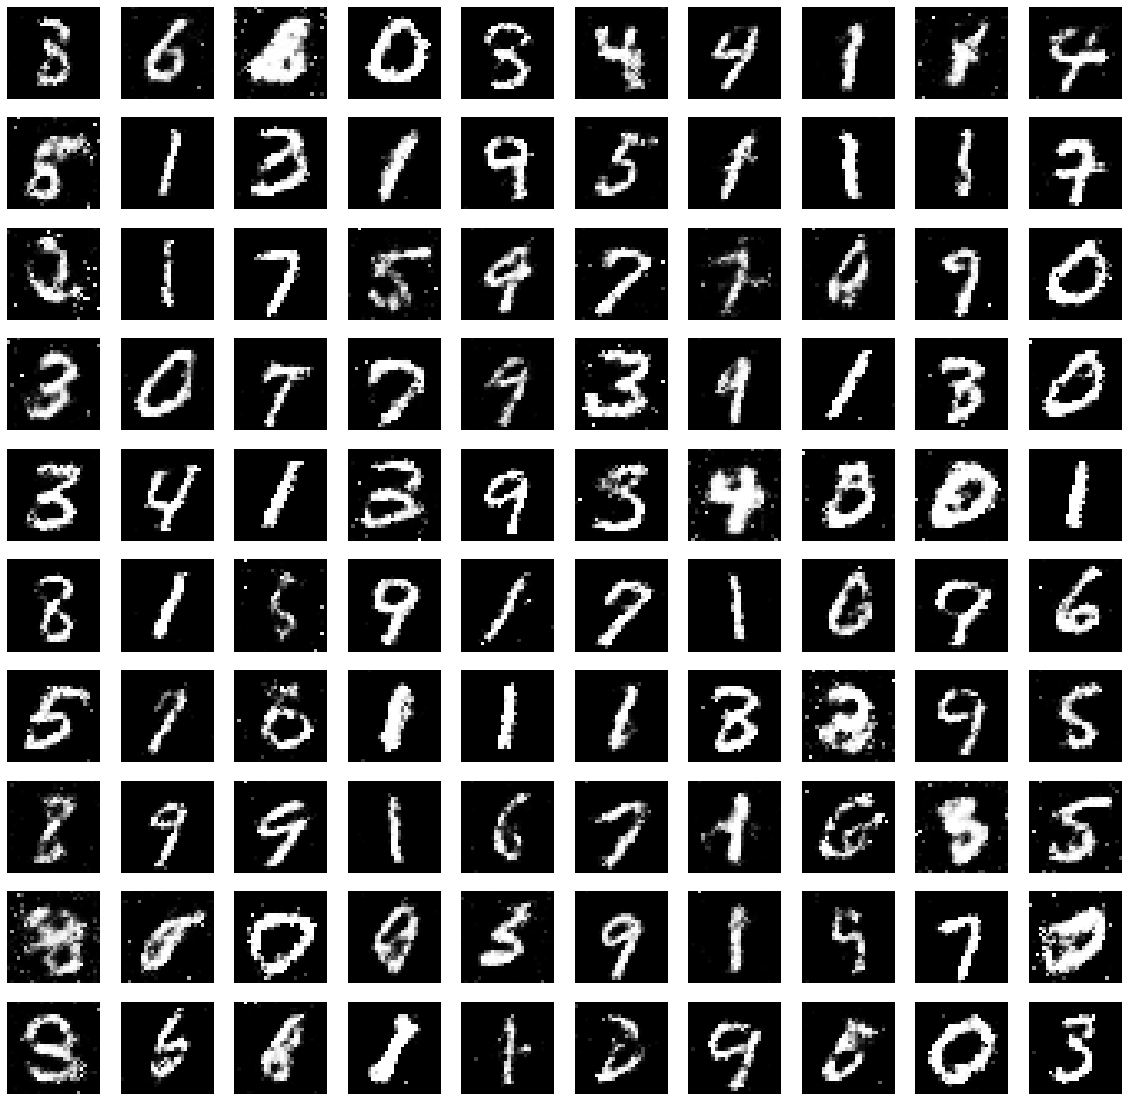

In [ ]:
#The output from the vanilla gan I trained on the MNIST data
show_images(np.random.normal(0, 1, size=(100, 100)), 'final')

In [212]:
#Importing the dependencies
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense, Conv2DTranspose, LeakyReLU, Input, Embedding, multiply, Reshape, Concatenate, Flatten, Dropout, BatchNormalization
from keras.models import Sequential, Model
from keras.optimizers import Adam

In [10]:
%matplotlib inline

11493376/11490434 [==============================] - 0s 0us/step


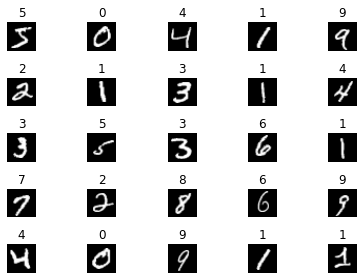

In [11]:
#Loading the dataset. This time I output them with their respective labels since we will need them.

from keras.datasets.mnist import load_data

(X_train, y_train), (X_test, y_test) = load_data()

#Plotting sample images
for i in range(25):
  # define subplot
  plt.subplot(5, 5, 1 + i)
  # turn off axis
  plt.axis('off')
  # plot raw pixel data
  plt.imshow(X_train[i], cmap='gray')
  plt.title(y_train[i])
plt.tight_layout()
plt.show()

In [12]:
#Normalizing and flattening the data
#The way we preprocess like this is so that it matches the output of the tanh layer
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = X_train.reshape(-1, 28*28)

In [14]:
#Getting the data dimensions
data_dim = X_train.shape

In [15]:
#Defining the dimension of the noise and the number of classes as they will be needed to create the models.

z_dim = 100
num_classes = 10

## The Generator Network

The biggest change here is that we need a model that can take both labels and noise as input and then output a vector in the shape of the desired data. We still keep a Sequential model as before to do the manipulation on the input, however, we cannot use the Sequential model for the whole network. For this we will use keras's Functional API and call it with the Model() class. This allows us to input multiple inputs inside our model. 

In line 30 below I create an input layer to take in the random noise. Then I create an Input layer for the desired label. I create an embedding of the label that matches the size of the noise and then we combine the two inputs together by multiplying them to create a joint representation. The embeddings are deterministic and doesn't change. This in a way allows us to sample random noise from 10 different prior distributions (one for each class). While thinking about how to implement this, I tried to concatenate the two inputs initially, however, it didn't give me great results while training. I came across to this approach on the internet and it worked very well. 

After we have the joint representation that becomes the input of the generator network which byitself a Sequential model.

In my vanilla GAN implementation, I figured out that LeakyReLU works well in the intermediate layers and tanh works well for the final layer, so I kept them the same. However, I also made some changes to the rest of the architecture as well. First of all, I shrunk down the number of neurons in each layer, which enabled the generator to keep up with the discriminator better. It avoids the diminishing gradients problem to a degree. I tried experimenting with Dropout layers, however, found out that it wasn't helpful so I discarded it (nonetheless, it could in fact be a good idea to include it). Another change I made was adding Batch Normalization layers after every dense layer, I found out that this helped convergence too. 

In the end I ended up with a model like the one below.

In [214]:
#Creating the generator network
def generator(z_dim):
  #Specifying the dimension of the data for the output
  dim= data_dim[1]

  #Create a sequential model
  generator = Sequential()
  
  #Add a couple of dense layer with LeakyReLU activation and batch normalizations.
  #Now we also have a shrunken model in terms of parameters.
  generator.add(Dense(128, input_shape=(z_dim,)))
  generator.add(LeakyReLU())
  generator.add(BatchNormalization(momentum=0.8))
  
  generator.add(Dense(256))
  generator.add(LeakyReLU())
  generator.add(BatchNormalization(momentum=0.8))

  generator.add(Dense(512))
  generator.add(LeakyReLU())
  generator.add(BatchNormalization(momentum=0.8))

  #generator.add(Dense(1024))
  #generator.add(LeakyReLU())

  #Using tanh activation at the final layer. The data dimension is outputted
  generator.add(Dense(dim, activation='tanh'))

  #Creating an input layer for the noise
  z = Input(shape=(z_dim,))
  
  #Creating an input label for the desired label
  label = Input(shape=(1,), dtype='int32')
  
  #Creating an embedding for the label that matches the noise dimensions
  label_embedding = Embedding(num_classes, z_dim, input_length=1)(label)

  #The embeding is a 3D tensor, here we transform it into a 2D tensor with the Flatten layer
  label_embedding = Flatten()(label_embedding)

  #We create a joint representation of the label embedding and the noise
  joined_representation = multiply([z, label_embedding])

  #Inputting the joint representation into the generator network
  img = generator(joined_representation)

  return Model([z, label], img)

  #I think it is important to note that we don't compile this model here with an optimizer. It will be using the optimizer of the bigger GAN model

## The Discriminator Network 

For the discriminator network the changes were similar. Again I needed a model that would take in multiple inputs. For this I used the Functional API of keras (there is some ambiguity with its name but it's the Model() class). 

To deal with the multiple inputs I used a similar way to the one I did in the generator model. However, this time, I created label embeddings that are the size of the inputted images and again created a joint representation of the label embeddings and the images. Then the joint representation, like before, is inputted into the discriminator network for classification. 

Also, similarly to the generator, I shrunk the size of the network I used. Now I train less parameters. I found out that this ensures a better performance.

Another thing that is very important is to use very low learning rates while training and updating the weights slowly. This avoids oscillations and makes convergence more likely. 

In [215]:
#Creating the discriminator
def discriminator():
  #We use this for the input size
  dim= data_dim[1]
  
  #Creating a sequential model
  discriminator = Sequential()

  #Adding layers that mirror the generator network. This isn't necessary, but is useful
  #discriminator.add(Dense(1024))
  #discriminator.add(LeakyReLU(0.2))
  
  discriminator.add(Dense(128))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dense(256))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dense(512))
  discriminator.add(LeakyReLU(0.2))
  #discriminator.add(Dense(100))
  #Using sigmoid activation for binary classification
  discriminator.add(Dense(1, activation='sigmoid'))

  #Creating an input layer for the images
  img = Input(shape=dim)

  #Creating an input layer for the labels
  label = Input(shape=(1,), dtype='int32')

  #Creating the layer embeddings for the labels that are the size of the images
  label_embedding = Embedding(input_dim=num_classes, output_dim=dim, input_length=1)(label)
  
  #Converting the 3D embeddings into 2D by flattening them
  label_embedding = Flatten()(label_embedding)
  
  
  #As I mentioned above, I tried concatenating, however, that din't really work
  #concatenated = Concatenate(axis=-1)([img, label_embedding])

  #Combining the embedding and the images
  prediction = discriminator(multiply([img, label_embedding]))

  return Model([img, label], prediction)

In [216]:
#Creating an instance of the generator
generator = generator(z_dim)

In [217]:
#Creating an instance of the discriminator

discriminator = discriminator()

#Adding the adam optimizer. Note that the learning rate is very low compared to the default setting
opt = Adam(learning_rate=0.0002, beta_1=0.5)

#Compiling the model
discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['binary_accuracy'])

In [218]:
#Looking at the summaries of the models
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       1000        input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 100)          0           embedding[0][0]                  
______________________________________________________________________________________________

In [219]:
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 784)       7840        input_4[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           embedding_1[0][0]                
____________________________________________________________________________________________

## Putting Together the CGAN

Here I put the two networks into a single model. I freeze the discriminator weights while training the CGAN so that it only gets updated when the discriminator is specifically trained on data. This assures that we can train the generator without improving the discriminator performance. This is important to avoid the failure modes.

In [220]:
#Creating the input layers
z = Input(shape=(z_dim,))
label = Input(shape=(1,))

img = generator([z, label])

#Freezing the discriminator weights while training the CGAN
discriminator.trainable = False

prediction = discriminator([img, label])

#Putting everything together
cgan = Model([z, label], prediction)

#Compiling the model with an optimizer. Notice that the learning rate is again very low.
opt = Adam(learning_rate=0.0002, beta_1=0.5)
cgan.compile(loss='binary_crossentropy', optimizer=opt)

In [221]:
cgan.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 784)          584312      input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            (None, 1)            273441      model[0][0]                

## Visualizing Outputs

The code below creates labels from 0 to 9 and inputs them into the generator to give us a visualization of each label

In [173]:
def sample_images(rows =2, cols=5):
  #Creating random noise
  z = np.random.normal(0, 1, (rows * cols, z_dim))
  #Creating labels for each class
  labels = np.arange(0, 10).reshape(-1, 1)
  
  #Creating images from the labels and the noise
  gen_imgs = generator.predict([z, labels])
  gen_imgs = 0.5 * gen_imgs + 0.5
  
  #Creating a subplot graph
  fig, axs = plt.subplots(rows, cols, figsize=(10,4), sharey=True, sharex=True)
  count=0
  
  #Looping and graphing each output
  for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(gen_imgs[count].reshape(28,28), cmap='gray')
            axs[i,j].axis('off')
            axs[i,j].set_title(str(labels[count]))
            count += 1

  plt.show()

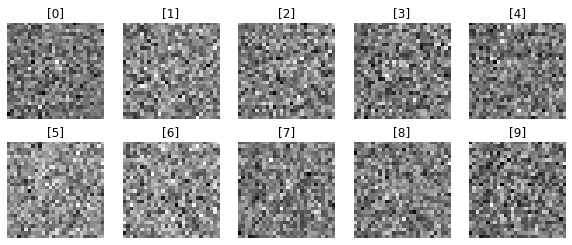

In [174]:
#A sample set of generated images before training
sample_images()

## Training

Training is very similar to before. However, now we also use the labels for training to.

Something I tried here was different combinations of smoothening the targeted labels so that we punish when the discriminator gets overconfident about the results. After trying with different specifications, I figured out that the best is to keep the real labels at 0.9 but the fake ones at 0 (which also happens to be the general convention). 

0 [D loss: [0.6936466693878174, 0.21875], [G loss: 0.6925802230834961]
0 [D loss: [0.2991797924041748, 0.46875], [G loss: 4.69216251373291]
0 [D loss: [0.40945449471473694, 0.375], [G loss: 3.662104368209839]
0 [D loss: [0.4459289014339447, 0.34375], [G loss: 2.748183250427246]
0 [D loss: [0.39269113540649414, 0.46875], [G loss: 2.220743179321289]
0 [D loss: [0.7375413179397583, 0.4375], [G loss: 1.513848066329956]
0 [D loss: [0.4305110275745392, 0.5], [G loss: 1.0689923763275146]
0 [D loss: [0.5240246653556824, 0.5], [G loss: 1.2770516872406006]
0 [D loss: [0.5360022783279419, 0.4375], [G loss: 1.5817997455596924]
0 [D loss: [0.6493217945098877, 0.46875], [G loss: 1.250935673713684]
0 [D loss: [0.6356490254402161, 0.34375], [G loss: 1.461850881576538]
0 [D loss: [0.6256117224693298, 0.25], [G loss: 1.1123878955841064]
0 [D loss: [0.6437176465988159, 0.4375], [G loss: 0.9120099544525146]


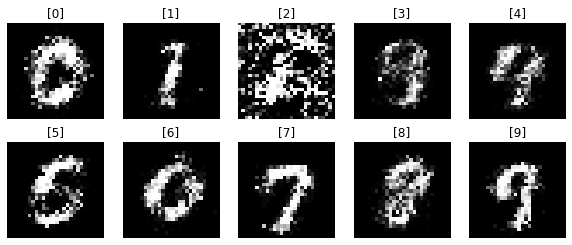

1 [D loss: [0.6490221619606018, 0.3125], [G loss: 1.1281253099441528]
1 [D loss: [0.6493687033653259, 0.4375], [G loss: 0.9620582461357117]
1 [D loss: [0.673653244972229, 0.40625], [G loss: 0.9219608902931213]
1 [D loss: [0.6303450465202332, 0.5], [G loss: 0.936555027961731]
1 [D loss: [0.6782576441764832, 0.40625], [G loss: 0.9263249635696411]
1 [D loss: [0.6400229930877686, 0.40625], [G loss: 1.0291402339935303]
1 [D loss: [0.6527034044265747, 0.4375], [G loss: 0.8936200141906738]
1 [D loss: [0.6214202642440796, 0.4375], [G loss: 0.9049006700515747]
1 [D loss: [0.6742407083511353, 0.34375], [G loss: 0.8730121850967407]
1 [D loss: [0.680030882358551, 0.46875], [G loss: 1.043722152709961]
1 [D loss: [0.6167929172515869, 0.46875], [G loss: 0.8671642541885376]
1 [D loss: [0.6545286178588867, 0.40625], [G loss: 0.8101723194122314]
1 [D loss: [0.6554074883460999, 0.46875], [G loss: 0.8518543839454651]


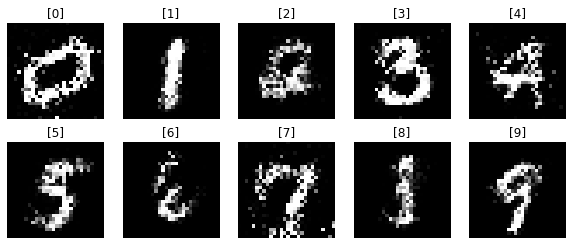

2 [D loss: [0.685600996017456, 0.3125], [G loss: 0.9167807698249817]
2 [D loss: [0.6963090896606445, 0.3125], [G loss: 0.9066678285598755]
2 [D loss: [0.6360635757446289, 0.40625], [G loss: 0.9568490386009216]
2 [D loss: [0.7050840258598328, 0.34375], [G loss: 0.8532122373580933]
2 [D loss: [0.659324586391449, 0.28125], [G loss: 1.0131953954696655]
2 [D loss: [0.6734166145324707, 0.40625], [G loss: 0.9931775331497192]
2 [D loss: [0.7053893804550171, 0.375], [G loss: 1.0494475364685059]
2 [D loss: [0.5908948183059692, 0.5], [G loss: 0.9787154197692871]
2 [D loss: [0.626686155796051, 0.46875], [G loss: 0.8479580879211426]
2 [D loss: [0.6439735889434814, 0.375], [G loss: 0.898047924041748]
2 [D loss: [0.7214237451553345, 0.40625], [G loss: 1.0322858095169067]
2 [D loss: [0.6513449549674988, 0.40625], [G loss: 0.8639401197433472]
2 [D loss: [0.6702901721000671, 0.375], [G loss: 1.045215129852295]


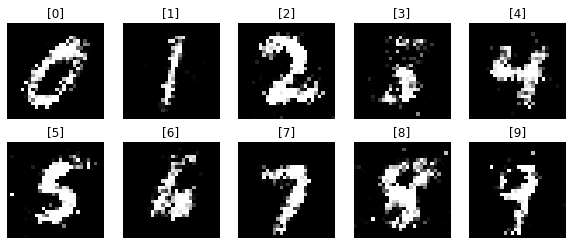

3 [D loss: [0.6844947338104248, 0.375], [G loss: 0.8793500661849976]
3 [D loss: [0.6802026033401489, 0.40625], [G loss: 0.9159742593765259]
3 [D loss: [0.6497226357460022, 0.4375], [G loss: 0.9434330463409424]
3 [D loss: [0.5623278021812439, 0.375], [G loss: 0.9860604405403137]
3 [D loss: [0.6379221677780151, 0.4375], [G loss: 0.9684135913848877]
3 [D loss: [0.6097148656845093, 0.40625], [G loss: 0.7418992519378662]
3 [D loss: [0.6124788522720337, 0.40625], [G loss: 0.933459997177124]
3 [D loss: [0.6253721714019775, 0.46875], [G loss: 1.2170870304107666]
3 [D loss: [0.6459631323814392, 0.4375], [G loss: 0.9596587419509888]
3 [D loss: [0.6077063083648682, 0.4375], [G loss: 0.8997830152511597]
3 [D loss: [0.6274533867835999, 0.40625], [G loss: 0.9176310300827026]
3 [D loss: [0.7137782573699951, 0.25], [G loss: 1.0603867769241333]
3 [D loss: [0.5999987721443176, 0.375], [G loss: 1.0591135025024414]


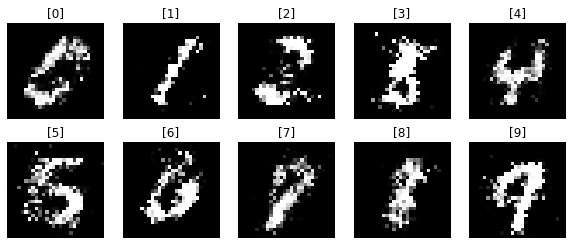

4 [D loss: [0.635854184627533, 0.46875], [G loss: 0.9045251607894897]
4 [D loss: [0.6384766101837158, 0.34375], [G loss: 0.9144705533981323]
4 [D loss: [0.5301153063774109, 0.46875], [G loss: 0.9913690090179443]
4 [D loss: [0.665483832359314, 0.3125], [G loss: 0.96318119764328]
4 [D loss: [0.6079148650169373, 0.40625], [G loss: 0.9111382961273193]
4 [D loss: [0.5769362449645996, 0.375], [G loss: 0.9667362570762634]
4 [D loss: [0.6458306312561035, 0.4375], [G loss: 1.0119390487670898]
4 [D loss: [0.7402420043945312, 0.375], [G loss: 0.9835375547409058]
4 [D loss: [0.6285943984985352, 0.375], [G loss: 0.832715630531311]
4 [D loss: [0.7001297473907471, 0.4375], [G loss: 0.9947904348373413]
4 [D loss: [0.6627181172370911, 0.46875], [G loss: 0.9171857237815857]
4 [D loss: [0.5954718589782715, 0.4375], [G loss: 0.9375380873680115]
4 [D loss: [0.6697868704795837, 0.375], [G loss: 1.0124616622924805]


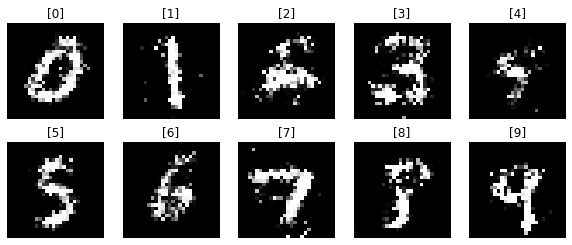

5 [D loss: [0.6164346933364868, 0.375], [G loss: 1.1374218463897705]
5 [D loss: [0.6371557712554932, 0.375], [G loss: 0.8622046113014221]
5 [D loss: [0.6142402291297913, 0.40625], [G loss: 1.1615580320358276]
5 [D loss: [0.585973858833313, 0.4375], [G loss: 1.2296067476272583]
5 [D loss: [0.6467962265014648, 0.40625], [G loss: 0.984684944152832]
5 [D loss: [0.7007336616516113, 0.375], [G loss: 1.1244066953659058]
5 [D loss: [0.6742966175079346, 0.4375], [G loss: 1.1160022020339966]
5 [D loss: [0.6745734214782715, 0.46875], [G loss: 0.9680480360984802]
5 [D loss: [0.6454470157623291, 0.3125], [G loss: 1.1606864929199219]
5 [D loss: [0.6027024388313293, 0.46875], [G loss: 1.1033010482788086]
5 [D loss: [0.6260972023010254, 0.40625], [G loss: 1.019313097000122]
5 [D loss: [0.6892995834350586, 0.4375], [G loss: 1.1199963092803955]
5 [D loss: [0.6850324273109436, 0.28125], [G loss: 0.9646041989326477]


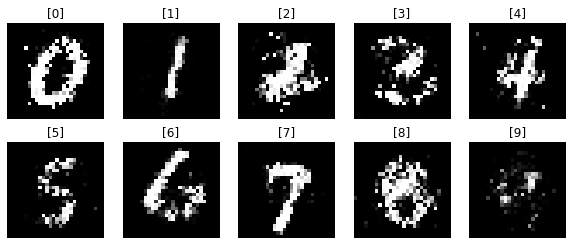

6 [D loss: [0.6437141299247742, 0.4375], [G loss: 1.2565696239471436]
6 [D loss: [0.6365455389022827, 0.4375], [G loss: 1.0977731943130493]
6 [D loss: [0.621444821357727, 0.3125], [G loss: 0.9012603163719177]
6 [D loss: [0.628754198551178, 0.3125], [G loss: 0.9188039302825928]
6 [D loss: [0.6067698001861572, 0.40625], [G loss: 0.9003658294677734]
6 [D loss: [0.6333156824111938, 0.375], [G loss: 0.9927871823310852]
6 [D loss: [0.5802596807479858, 0.40625], [G loss: 0.9921309351921082]
6 [D loss: [0.6274887919425964, 0.46875], [G loss: 1.0686872005462646]
6 [D loss: [0.607756495475769, 0.5], [G loss: 1.165865421295166]
6 [D loss: [0.5607465505599976, 0.5], [G loss: 1.1788218021392822]
6 [D loss: [0.5920438766479492, 0.375], [G loss: 0.9325152039527893]
6 [D loss: [0.5450732111930847, 0.46875], [G loss: 0.9388039112091064]
6 [D loss: [0.6450415849685669, 0.375], [G loss: 0.9783675074577332]


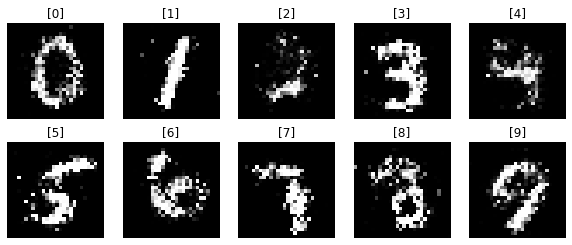

7 [D loss: [0.5367343425750732, 0.4375], [G loss: 1.076318383216858]
7 [D loss: [0.6928248405456543, 0.4375], [G loss: 1.0021077394485474]
7 [D loss: [0.6054482460021973, 0.5], [G loss: 0.9567656517028809]
7 [D loss: [0.6332839727401733, 0.46875], [G loss: 1.0317339897155762]
7 [D loss: [0.6125736236572266, 0.4375], [G loss: 1.1627161502838135]
7 [D loss: [0.6436052322387695, 0.46875], [G loss: 1.1665350198745728]
7 [D loss: [0.6825319528579712, 0.34375], [G loss: 0.9040076732635498]
7 [D loss: [0.6220995187759399, 0.4375], [G loss: 0.9349355697631836]
7 [D loss: [0.6273574829101562, 0.34375], [G loss: 1.1719884872436523]
7 [D loss: [0.649671196937561, 0.4375], [G loss: 1.029820203781128]
7 [D loss: [0.6159681081771851, 0.40625], [G loss: 0.9202020764350891]
7 [D loss: [0.6895523071289062, 0.375], [G loss: 1.1327590942382812]
7 [D loss: [0.6348261833190918, 0.46875], [G loss: 1.1541467905044556]


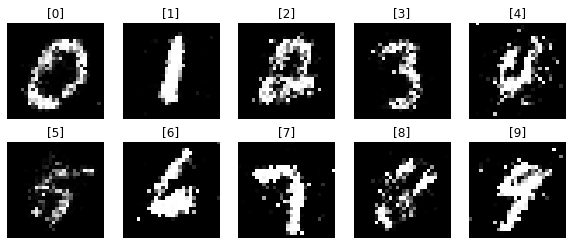

8 [D loss: [0.6890938878059387, 0.34375], [G loss: 0.9225859642028809]
8 [D loss: [0.5315427184104919, 0.46875], [G loss: 0.9683865308761597]
8 [D loss: [0.620741605758667, 0.40625], [G loss: 0.9957431554794312]
8 [D loss: [0.677658200263977, 0.3125], [G loss: 0.8711408376693726]
8 [D loss: [0.5500465631484985, 0.46875], [G loss: 1.02302086353302]
8 [D loss: [0.6424471735954285, 0.375], [G loss: 1.1254734992980957]
8 [D loss: [0.674480140209198, 0.4375], [G loss: 0.8562489151954651]
8 [D loss: [0.6714264154434204, 0.28125], [G loss: 0.9472077488899231]
8 [D loss: [0.6586194038391113, 0.34375], [G loss: 1.2043049335479736]
8 [D loss: [0.6778024435043335, 0.375], [G loss: 0.9787031412124634]
8 [D loss: [0.5900675058364868, 0.5], [G loss: 1.173880696296692]
8 [D loss: [0.6010239720344543, 0.4375], [G loss: 1.061753511428833]
8 [D loss: [0.6734393835067749, 0.4375], [G loss: 1.0564029216766357]


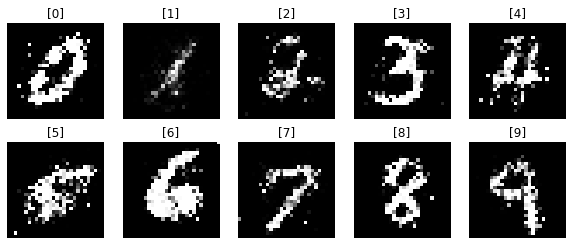

9 [D loss: [0.6699457168579102, 0.4375], [G loss: 1.1178569793701172]
9 [D loss: [0.514818549156189, 0.4375], [G loss: 1.1337411403656006]
9 [D loss: [0.6615414023399353, 0.375], [G loss: 1.100333571434021]
9 [D loss: [0.6835852861404419, 0.40625], [G loss: 1.0827407836914062]
9 [D loss: [0.5798094272613525, 0.5], [G loss: 1.2865374088287354]
9 [D loss: [0.6161868572235107, 0.40625], [G loss: 1.2430775165557861]
9 [D loss: [0.5994048118591309, 0.4375], [G loss: 0.987246572971344]
9 [D loss: [0.5975311994552612, 0.4375], [G loss: 0.9902387857437134]
9 [D loss: [0.6189265251159668, 0.375], [G loss: 0.8827399015426636]
9 [D loss: [0.6629414558410645, 0.4375], [G loss: 1.1415562629699707]
9 [D loss: [0.5972139835357666, 0.4375], [G loss: 0.987140417098999]
9 [D loss: [0.6463378667831421, 0.4375], [G loss: 1.0349408388137817]
9 [D loss: [0.5837219953536987, 0.4375], [G loss: 0.782936155796051]


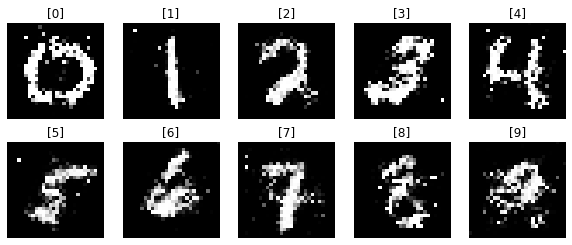

10 [D loss: [0.6784881353378296, 0.375], [G loss: 0.9456942677497864]
10 [D loss: [0.6826252937316895, 0.34375], [G loss: 0.9498436450958252]
10 [D loss: [0.6263776421546936, 0.3125], [G loss: 1.0385067462921143]
10 [D loss: [0.7160616517066956, 0.3125], [G loss: 1.057434320449829]
10 [D loss: [0.6816849708557129, 0.34375], [G loss: 0.9049602746963501]
10 [D loss: [0.5784894227981567, 0.40625], [G loss: 1.0970230102539062]
10 [D loss: [0.7304142713546753, 0.4375], [G loss: 1.0207880735397339]
10 [D loss: [0.7145915031433105, 0.40625], [G loss: 0.9445533156394958]
10 [D loss: [0.6307439804077148, 0.28125], [G loss: 0.8999948501586914]
10 [D loss: [0.6303608417510986, 0.375], [G loss: 1.0673747062683105]
10 [D loss: [0.6317933201789856, 0.5], [G loss: 1.13492751121521]
10 [D loss: [0.6037145853042603, 0.4375], [G loss: 1.1436094045639038]
10 [D loss: [0.6205344796180725, 0.40625], [G loss: 1.0704435110092163]


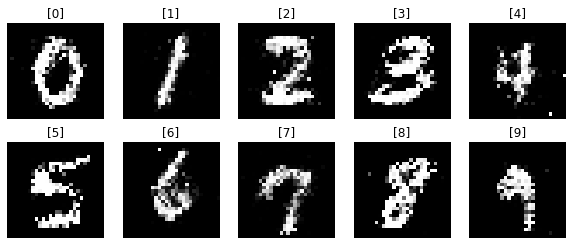

11 [D loss: [0.5585829019546509, 0.40625], [G loss: 1.1361815929412842]
11 [D loss: [0.6263664364814758, 0.40625], [G loss: 1.0980479717254639]
11 [D loss: [0.5854978561401367, 0.4375], [G loss: 0.9850016832351685]
11 [D loss: [0.6079137325286865, 0.40625], [G loss: 0.9165941476821899]
11 [D loss: [0.6025991439819336, 0.4375], [G loss: 0.9696168899536133]
11 [D loss: [0.6139715909957886, 0.3125], [G loss: 1.1063001155853271]
11 [D loss: [0.6443674564361572, 0.40625], [G loss: 1.0954086780548096]
11 [D loss: [0.6575033664703369, 0.34375], [G loss: 1.0531657934188843]
11 [D loss: [0.6535692811012268, 0.4375], [G loss: 1.1567859649658203]
11 [D loss: [0.5621774196624756, 0.46875], [G loss: 1.0680540800094604]
11 [D loss: [0.682289719581604, 0.375], [G loss: 1.0547685623168945]
11 [D loss: [0.6728078722953796, 0.46875], [G loss: 1.1228220462799072]
11 [D loss: [0.5744410157203674, 0.46875], [G loss: 1.0925757884979248]


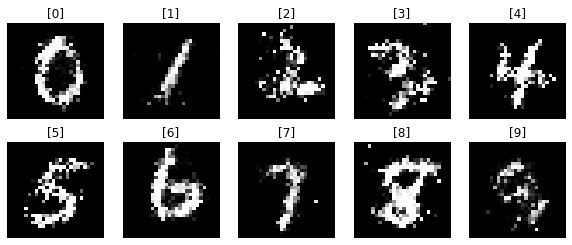

12 [D loss: [0.6410911083221436, 0.40625], [G loss: 0.8725042939186096]
12 [D loss: [0.5828418731689453, 0.46875], [G loss: 1.030070424079895]
12 [D loss: [0.5709765553474426, 0.40625], [G loss: 0.9141826033592224]
12 [D loss: [0.7144874334335327, 0.40625], [G loss: 1.1202269792556763]
12 [D loss: [0.5633909702301025, 0.46875], [G loss: 1.28330659866333]
12 [D loss: [0.6031392812728882, 0.34375], [G loss: 1.05149245262146]
12 [D loss: [0.5549096465110779, 0.4375], [G loss: 1.1133701801300049]
12 [D loss: [0.6030281782150269, 0.4375], [G loss: 1.031172275543213]
12 [D loss: [0.545545220375061, 0.4375], [G loss: 1.221329927444458]
12 [D loss: [0.6013784408569336, 0.5], [G loss: 0.871988832950592]
12 [D loss: [0.6139292120933533, 0.4375], [G loss: 0.9465595483779907]
12 [D loss: [0.6075829863548279, 0.40625], [G loss: 1.2535885572433472]
12 [D loss: [0.6389415264129639, 0.5], [G loss: 1.2266162633895874]


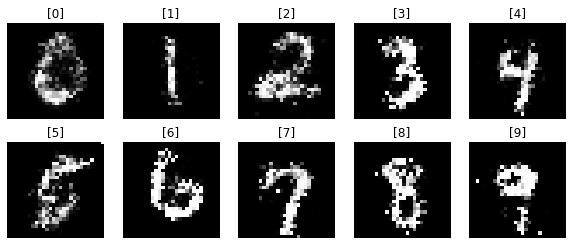

13 [D loss: [0.5704033374786377, 0.4375], [G loss: 1.0810246467590332]
13 [D loss: [0.5790859460830688, 0.4375], [G loss: 1.063600778579712]
13 [D loss: [0.6921221017837524, 0.5], [G loss: 1.1933488845825195]
13 [D loss: [0.6994059085845947, 0.34375], [G loss: 0.9779270887374878]
13 [D loss: [0.6442132592201233, 0.40625], [G loss: 1.0357959270477295]
13 [D loss: [0.6109795570373535, 0.40625], [G loss: 1.169191837310791]
13 [D loss: [0.566364586353302, 0.375], [G loss: 1.3478169441223145]
13 [D loss: [0.643917441368103, 0.40625], [G loss: 1.0873150825500488]
13 [D loss: [0.6771959066390991, 0.40625], [G loss: 1.023977279663086]
13 [D loss: [0.5668992400169373, 0.46875], [G loss: 0.9724262952804565]
13 [D loss: [0.5893774032592773, 0.34375], [G loss: 1.0551700592041016]
13 [D loss: [0.5279732346534729, 0.46875], [G loss: 1.1332546472549438]
13 [D loss: [0.6519556045532227, 0.46875], [G loss: 1.0222169160842896]


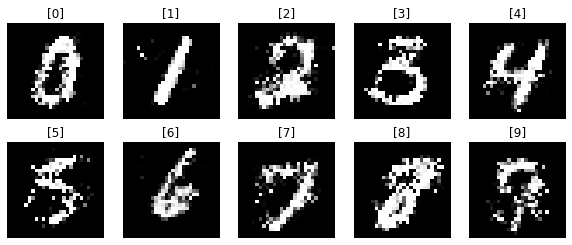

14 [D loss: [0.6333554983139038, 0.40625], [G loss: 1.067038655281067]
14 [D loss: [0.6304028034210205, 0.375], [G loss: 1.0111051797866821]
14 [D loss: [0.6149461269378662, 0.4375], [G loss: 1.0626049041748047]
14 [D loss: [0.6548597812652588, 0.4375], [G loss: 1.1087265014648438]
14 [D loss: [0.6429216861724854, 0.4375], [G loss: 0.9169706702232361]
14 [D loss: [0.6470335125923157, 0.375], [G loss: 1.2139902114868164]
14 [D loss: [0.6451297998428345, 0.28125], [G loss: 1.043931245803833]
14 [D loss: [0.5751907825469971, 0.46875], [G loss: 0.992628276348114]
14 [D loss: [0.5643467307090759, 0.375], [G loss: 0.9953063130378723]
14 [D loss: [0.6110429167747498, 0.46875], [G loss: 1.1986098289489746]
14 [D loss: [0.6068918108940125, 0.4375], [G loss: 1.1204307079315186]
14 [D loss: [0.5789535045623779, 0.4375], [G loss: 1.046212911605835]
14 [D loss: [0.65589839220047, 0.4375], [G loss: 1.130408763885498]


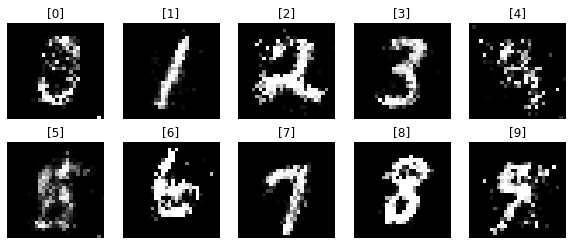

15 [D loss: [0.7063977122306824, 0.34375], [G loss: 0.8696470856666565]
15 [D loss: [0.5671119689941406, 0.46875], [G loss: 1.0389764308929443]
15 [D loss: [0.6865437626838684, 0.375], [G loss: 1.111038088798523]
15 [D loss: [0.5232659578323364, 0.46875], [G loss: 0.940692663192749]
15 [D loss: [0.6348294019699097, 0.46875], [G loss: 0.9633444547653198]
15 [D loss: [0.6537297964096069, 0.4375], [G loss: 0.9374037981033325]
15 [D loss: [0.6128015518188477, 0.46875], [G loss: 1.2854286432266235]
15 [D loss: [0.6036956906318665, 0.375], [G loss: 1.1016297340393066]
15 [D loss: [0.6414510011672974, 0.40625], [G loss: 1.0950226783752441]
15 [D loss: [0.54594486951828, 0.46875], [G loss: 1.1798906326293945]
15 [D loss: [0.5374986529350281, 0.4375], [G loss: 1.1828330755233765]
15 [D loss: [0.601326048374176, 0.40625], [G loss: 1.171859622001648]
15 [D loss: [0.5758917331695557, 0.40625], [G loss: 0.9478009939193726]


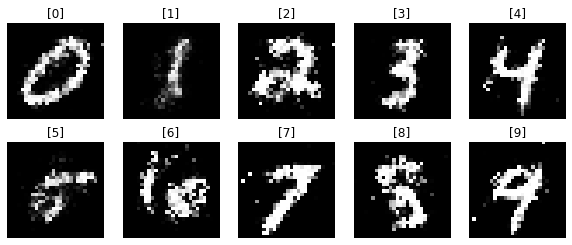

16 [D loss: [0.6672059893608093, 0.40625], [G loss: 1.0297785997390747]
16 [D loss: [0.5998849272727966, 0.40625], [G loss: 1.2538819313049316]
16 [D loss: [0.5737020969390869, 0.5], [G loss: 1.0632089376449585]
16 [D loss: [0.6385713219642639, 0.40625], [G loss: 1.1571811437606812]
16 [D loss: [0.626447856426239, 0.46875], [G loss: 1.0942720174789429]
16 [D loss: [0.6243082284927368, 0.375], [G loss: 0.895919919013977]
16 [D loss: [0.6339668035507202, 0.375], [G loss: 1.0265836715698242]
16 [D loss: [0.5942807197570801, 0.40625], [G loss: 1.0987823009490967]
16 [D loss: [0.6466641426086426, 0.375], [G loss: 1.1120927333831787]
16 [D loss: [0.5702715516090393, 0.46875], [G loss: 1.2785468101501465]
16 [D loss: [0.663322389125824, 0.34375], [G loss: 1.1371424198150635]
16 [D loss: [0.6881627440452576, 0.375], [G loss: 0.938910722732544]
16 [D loss: [0.6873887777328491, 0.375], [G loss: 1.1595277786254883]


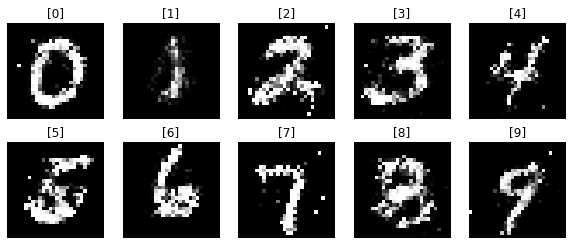

17 [D loss: [0.6001555323600769, 0.40625], [G loss: 1.1255724430084229]
17 [D loss: [0.6926437616348267, 0.40625], [G loss: 1.003032922744751]
17 [D loss: [0.6168202757835388, 0.4375], [G loss: 1.175032377243042]
17 [D loss: [0.6407760381698608, 0.34375], [G loss: 1.0479234457015991]
17 [D loss: [0.5811838507652283, 0.40625], [G loss: 1.0698004961013794]
17 [D loss: [0.6635435819625854, 0.40625], [G loss: 1.1284629106521606]
17 [D loss: [0.6007252931594849, 0.40625], [G loss: 1.0119569301605225]
17 [D loss: [0.6632847785949707, 0.46875], [G loss: 1.003387451171875]
17 [D loss: [0.613426148891449, 0.46875], [G loss: 1.0498437881469727]
17 [D loss: [0.6216400861740112, 0.4375], [G loss: 0.8890969753265381]
17 [D loss: [0.5712494850158691, 0.4375], [G loss: 1.0549089908599854]
17 [D loss: [0.7074155211448669, 0.4375], [G loss: 1.1176339387893677]
17 [D loss: [0.6686596870422363, 0.4375], [G loss: 1.112595558166504]


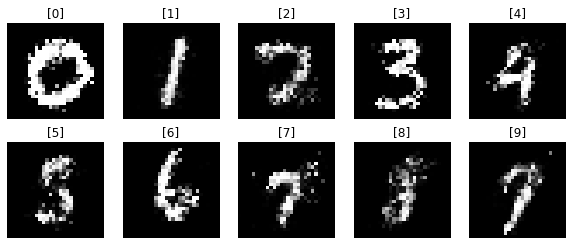

18 [D loss: [0.6900283098220825, 0.4375], [G loss: 1.0406885147094727]
18 [D loss: [0.6261441111564636, 0.3125], [G loss: 1.0595569610595703]
18 [D loss: [0.6547315120697021, 0.3125], [G loss: 1.0491588115692139]
18 [D loss: [0.5280225872993469, 0.46875], [G loss: 1.1856653690338135]
18 [D loss: [0.6141365766525269, 0.46875], [G loss: 1.0782896280288696]
18 [D loss: [0.5656471252441406, 0.46875], [G loss: 1.1744728088378906]
18 [D loss: [0.6618579626083374, 0.46875], [G loss: 1.150886058807373]
18 [D loss: [0.6388694047927856, 0.375], [G loss: 1.0132668018341064]
18 [D loss: [0.6501766443252563, 0.4375], [G loss: 1.1893277168273926]
18 [D loss: [0.7030707001686096, 0.34375], [G loss: 1.076788306236267]
18 [D loss: [0.6855790019035339, 0.34375], [G loss: 1.1973140239715576]
18 [D loss: [0.6001492738723755, 0.46875], [G loss: 1.1382027864456177]
18 [D loss: [0.6931208372116089, 0.4375], [G loss: 1.2502038478851318]


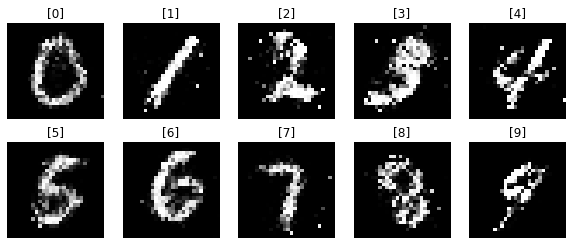

19 [D loss: [0.6217544078826904, 0.40625], [G loss: 1.0846443176269531]
19 [D loss: [0.6257702112197876, 0.40625], [G loss: 1.0898749828338623]
19 [D loss: [0.6924604177474976, 0.34375], [G loss: 1.181158185005188]
19 [D loss: [0.6616894006729126, 0.4375], [G loss: 1.0446003675460815]
19 [D loss: [0.6357524394989014, 0.4375], [G loss: 0.8077710866928101]
19 [D loss: [0.65598464012146, 0.40625], [G loss: 1.1808409690856934]
19 [D loss: [0.5766286849975586, 0.40625], [G loss: 1.1008758544921875]
19 [D loss: [0.7074548602104187, 0.375], [G loss: 1.3370144367218018]
19 [D loss: [0.6022124290466309, 0.375], [G loss: 1.0060405731201172]
19 [D loss: [0.6210264563560486, 0.4375], [G loss: 1.0460182428359985]
19 [D loss: [0.7039967775344849, 0.375], [G loss: 1.2148252725601196]
19 [D loss: [0.5695350766181946, 0.40625], [G loss: 0.9605417251586914]
19 [D loss: [0.6082404851913452, 0.4375], [G loss: 0.964139461517334]


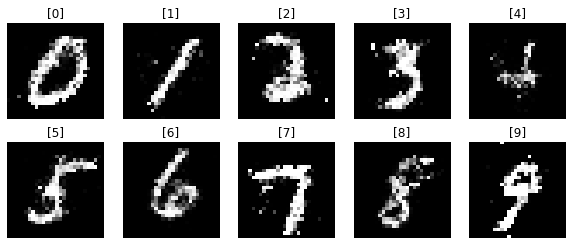

In [222]:
#Defining the hyperparameters
epochs = 20
batch_size = 16
steps = 60000//batch_size

#This time I record the losses and accuracies
accuracies = []
losses = []

#Creating labels for the real and the generated data (this is whether a data is real or fake)

#The labels for the real data are set to be 0.9
real = np.ones(shape=(batch_size, 1))
real[:len(real)] = 0.9

#The labels for the fake data are set to be 0
fake = np.zeros(shape=(batch_size, 1))
#fake[:len(fake)] = 0.1

#Concatenating the labels together
ys = np.concatenate((real, fake))

#Looping for each epoch
for epoch in range(epochs):
  #Looping for each batch
  for batch in range(steps):

    #Getting random indices to sample as our batch
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    #Getting the corresponding images and labels
    imgs, labels = X_train[idx], y_train[idx]

    #Creating random noise
    z = np.random.normal(0, 1, size=(batch_size, z_dim))

    #Generating images from the random noise and the labels of the actual data
    gen_imgs = generator.predict([z, labels])

    #Concatenating the real and the fake data together for inputting to the model
    input_images = np.concatenate((imgs, gen_imgs))
    #Concatenating labels twice since the labels will be the same for the real and the fake data (these labels are which category the data belongs to)
    labels = np.concatenate((labels, labels))

    #Training the discriminator
    d_loss = discriminator.train_on_batch([input_images, labels], ys)

    #Creating random noise to train the generator
    z = np.random.normal(0, 1, size=(batch_size, z_dim))
    
    #Getting labels for the generated images
    labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
    
    #Creating opposite labels so that we maximize the discriminator loss
    gan_y = np.ones(shape=(batch_size, 1))
    #Training the generator
    g_loss = cgan.train_on_batch([z, labels], gan_y)

    #Every 300 batches we print the results so we can keep track of what's going on
    if batch%300 == 0:
      print('{} [D loss: {}, [G loss: {}]'.format(epoch, d_loss, g_loss))
      losses.append((d_loss, g_loss))
  #Every epoch we print the images
  sample_images()


The final output of the model for every class

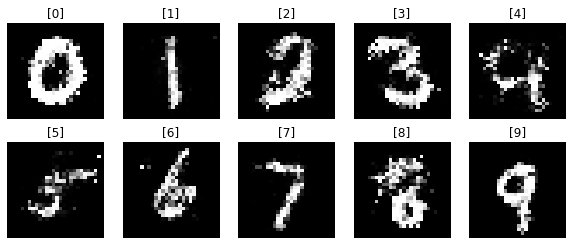

In [223]:
sample_images()

## Checking the Losses and Accuracy

In [240]:
np_losses = np.array(losses)
disc_losses = []
gen_losses = []

disc_accuracy = []

for elem in np_losses:
  disc_losses.append(elem[0][0])
  disc_accuracy.append(elem[0][1])
  gen_losses.append(elem[1])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


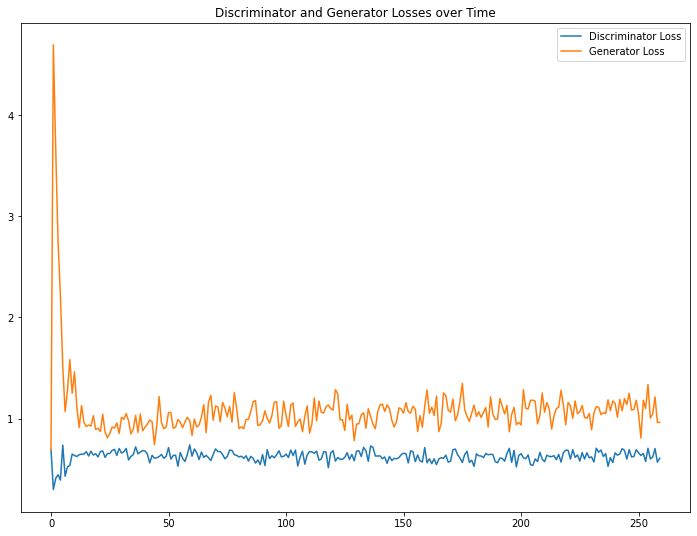

In [242]:
#Checking the losses
plt.figure(figsize=(12, 9))
plt.plot(disc_losses, label='Discriminator Loss')
plt.plot(gen_losses, label='Generator Loss')
plt.title('Discriminator and Generator Losses over Time')
plt.legend()
plt.show()



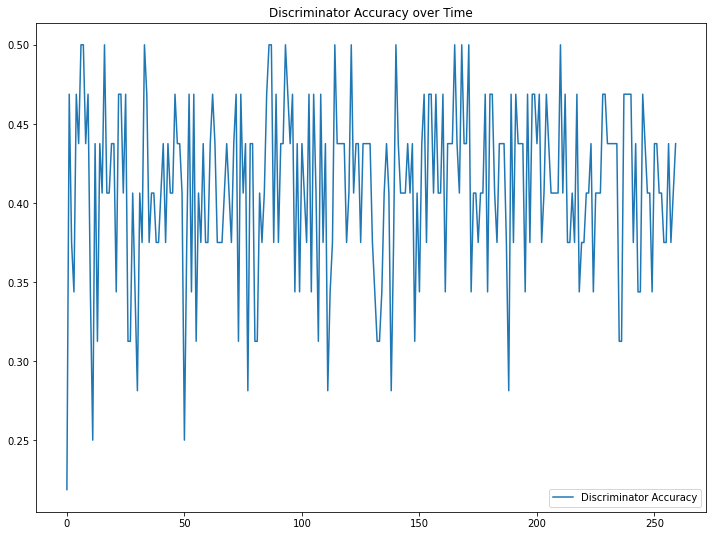

In [243]:
#Checking the discriminator accuracies
plt.figure(figsize=(12, 9))
plt.plot(disc_accuracy, label='Discriminator Accuracy')
plt.title('Discriminator Accuracy over Time')
plt.legend()
plt.show()

As it can be seen the discrimator and the generator losses are as expected (generator slightly over 1 and discriminator sligthly below 1). The discriminator accuracy is a little bit below 0.5, which is the theoretical estimate for convergence. This could be because we harm the discriminator a little bit by smoothening the labels, so the performance is also a little bit hindered

# Failure Modes

Similar to the vanilla GAN, I experienced some failure modes. The main ways I tackled these were by having a solid input representation by using embeddings and multiplying it with the other model input. Another one was adding batch normalization. And another one was using smaller models for the whole process. There are definitely other elements as well which I mentioned above, but I think these three were the main improvements. I also used all of the expertise and knowledge I gained while working with vanilla GANs such as activation functions or learning rates, which I will not really get into here.

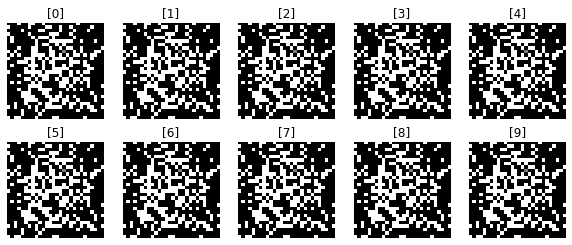

In [137]:
sample_images()

## Further Work

Now that we have a nicely working CGAN, we can talk about what can be further extensions to this. The most obvious one is the data we're working with. MNIST data is only 28x28 and it was painful to get the model to work. However, a similar model can be used to generate much more complicated pictures with more complicated labels. For that we would need more data, and much longer training times. The model here takes more than half an hour to run and such big models might take days to converge. 

However, after seeing the DALL-E model, I believe that using decoders, in fact, could be the future of the data generating processes. The outputs of the DALL-E model is just astonishing. I think in the future, I would like to experiment data generation with transformer-like architectures. Also, as GPUs and TPUs become more widespread (wait for 5 years), we will look back to these days and laugh at the models that we're training right now.

## Resources:

- https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/
- https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/
- https://anderfernandez.com/en/blog/how-to-code-gan-in-python/
- https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/
- https://medium.com/analytics-vidhya/implementing-a-gan-in-keras-d6c36bc6ab5f
- https://medium.com/@mafda_/gans-conditional-gans-with-mnist-part-4-7f816d274d8c
- https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/
- https://livebook.manning.com/book/gans-in-action/chapter-8/
